In [10]:
!pip install torch --quiet

In [4]:
# 04-attention-model-training.ipynb
# Openbook ML Demo - Attention-Based Copay Prediction Model

"""
Model Architecture:
- Multi-head self-attention to capture procedure interactions
- When multiple procedures compete for annual maximum, attention learns dependencies
- Example: Crown (D2750) exhausting max affects Root Canal (D3310) copay

Why Attention:
- Variable-length procedure lists per patient
- Procedures interact (compete for annual max, bundling rules)
- Interpretable attention weights show which procedures affect each other
"""

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from google.cloud import storage
from io import StringIO
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Configuration
PROJECT_ID = "openbook-ml-demo"
REGION = "us-central1"
BUCKET_NAME = "openbook-data-lake"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Load data from GCS
client = storage.Client(project=PROJECT_ID)
bucket = client.bucket(BUCKET_NAME)

def load_csv_from_gcs(path):
    blob = bucket.blob(path)
    return pd.read_csv(StringIO(blob.download_as_text()))

train_df = load_csv_from_gcs("processed/features/train.csv")
val_df = load_csv_from_gcs("processed/features/val.csv")
test_df = load_csv_from_gcs("processed/features/test.csv")

print(f"Train: {len(train_df):,}")
print(f"Val: {len(val_df):,}")
print(f"Test: {len(test_df):,}")

Device: cpu
Train: 7,000
Val: 1,500
Test: 1,500


In [5]:
# Define feature columns and prepare data

feature_cols = [
    'procedure_cost', 'annual_maximum', 'remaining_maximum', 'deductible_remaining',
    'coverage_ratio', 'months_enrolled', 'max_utilization', 'cost_to_max_ratio',
    'deductible_applies', 'network_penalty', 'waiting_period_risk',
    'is_preventive', 'is_basic', 'is_major', 'high_cost_procedure',
    'is_ppo', 'is_dhmo', 'is_indemnity',
    'carrier_delta_dental', 'carrier_cigna', 'carrier_aetna',
    'carrier_metlife', 'carrier_guardian', 'expected_copay'
]

target_col = 'patient_copay'

# Extract features and targets
X_train = train_df[feature_cols].values
y_train = train_df[target_col].values

X_val = val_df[feature_cols].values
y_val = val_df[target_col].values

X_test = test_df[feature_cols].values
y_test = test_df[target_col].values

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train_scaled)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)

X_val_t = torch.FloatTensor(X_val_scaled)
y_val_t = torch.FloatTensor(y_val).unsqueeze(1)

X_test_t = torch.FloatTensor(X_test_scaled)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

# Create DataLoaders
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
test_dataset = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")
print(f"X_train shape: {X_train_t.shape}")
print(f"y_train shape: {y_train_t.shape}")

Features: 24
Target: patient_copay
X_train shape: torch.Size([7000, 24])
y_train shape: torch.Size([7000, 1])


In [13]:
!pip install pytorch-lightning --quiet

In [6]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

class CopayAttentionLightning(pl.LightningModule):
    
    def __init__(self, input_dim=24, embed_dim=128, num_heads=4, dropout=0.1, lr=0.001):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        
        self.feature_encoder = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
        )
        
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.attention_norm = nn.LayerNorm(embed_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 2, embed_dim),
        )
        self.ffn_norm = nn.LayerNorm(embed_dim)
        
        self.output_layer = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        self.attention_weights = None
    
    def forward(self, x):
        encoded = self.feature_encoder(x)
        encoded = encoded.unsqueeze(1)
        attended, self.attention_weights = self.attention(encoded, encoded, encoded, need_weights=True)
        attended = self.attention_norm(attended + encoded)
        ffn_out = self.ffn(attended)
        ffn_out = self.ffn_norm(ffn_out + attended)
        output = ffn_out.squeeze(1)
        return self.output_layer(output)
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = nn.functional.mse_loss(pred, y)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        pred = self(x)
        loss = nn.functional.mse_loss(pred, y)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}


model = CopayAttentionLightning(input_dim=24, embed_dim=128, num_heads=4, dropout=0.1, lr=0.001)

checkpoint_callback = ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, filename='best-model')
early_stop_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min')

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[checkpoint_callback, early_stop_callback],
    enable_progress_bar=True,
)

trainer.fit(model, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type               ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ feature_encoder │ Sequential         │ 20.2 K │ train │     0 │
│ 1 │ attention       │ MultiheadAttention │ 66.0 K │ train │     0 │
│ 2 │ attention_norm  │ LayerNorm          │    256 │ train │     0 │
│ 3 │ ffn             │ Sequential         │ 65.9 K │ train │     0 │
│ 4 │ ffn_norm        │ LayerNorm          │    256 │ train │     0 │
│ 5 │ output_layer    │ Sequential         │  8.3 K │ train │     0 │
└───┴─────────────────┴────────────────────┴────────┴───────┴───────┘

Trainable params: 161 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 161 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 22                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

In [7]:
# Evaluate on test set
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        pred = model(batch_X)
        predictions.extend(pred.squeeze().numpy())
        actuals.extend(batch_y.squeeze().numpy())

predictions = np.array(predictions)
actuals = np.array(actuals)

# Metrics
mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print("Test Set Performance:")
print("=" * 40)
print(f"MAE:  ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²:   {r2:.4f}")

Test Set Performance:
MAE:  $29.72
RMSE: $86.44
R²:   0.9586


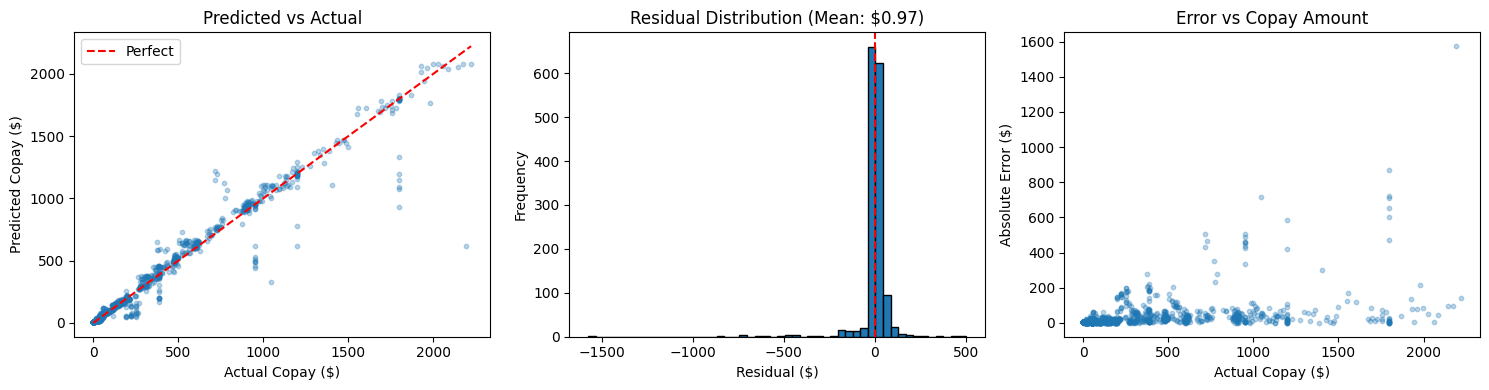

✓ Saved to GCS


In [8]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Predicted vs Actual scatter
ax1 = axes[0]
ax1.scatter(actuals, predictions, alpha=0.3, s=10)
ax1.plot([0, actuals.max()], [0, actuals.max()], 'r--', label='Perfect')
ax1.set_xlabel('Actual Copay ($)')
ax1.set_ylabel('Predicted Copay ($)')
ax1.set_title('Predicted vs Actual')
ax1.legend()

# 2. Residual distribution
ax2 = axes[1]
residuals = predictions - actuals
ax2.hist(residuals, bins=50, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_xlabel('Residual ($)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Residual Distribution (Mean: ${residuals.mean():.2f})')

# 3. Error by copay amount
ax3 = axes[2]
ax3.scatter(actuals, np.abs(residuals), alpha=0.3, s=10)
ax3.set_xlabel('Actual Copay ($)')
ax3.set_ylabel('Absolute Error ($)')
ax3.set_title('Error vs Copay Amount')

plt.tight_layout()
plt.savefig('model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

# Save to GCS
blob = bucket.blob('figures/model_performance.png')
blob.upload_from_filename('model_performance.png')
print("✓ Saved to GCS")

In [9]:
# Save baseline metrics for comparison
baseline_metrics = {
    "mae": mae,
    "rmse": rmse,
    "r2": r2,
    "embed_dim": 128,
    "num_heads": 4,
    "dropout": 0.1,
    "lr": 0.001
}

print("Baseline Model:")
print(f"  MAE:  ${baseline_metrics['mae']:.2f}")
print(f"  RMSE: ${baseline_metrics['rmse']:.2f}")
print(f"  R²:   {baseline_metrics['r2']:.4f}")
print("\nNow tuning with Vertex AI Vizier...")

Baseline Model:
  MAE:  $29.72
  RMSE: $86.44
  R²:   0.9586

Now tuning with Vertex AI Vizier...


In [10]:
# Vertex AI Vizier Hyperparameter Tuning
from google.cloud import aiplatform
from google.cloud.aiplatform_v1.types import study as study_pb2
from google.cloud.aiplatform_v1 import VizierServiceClient
import mlflow
import time

aiplatform.init(project=PROJECT_ID, location=REGION)
mlflow.set_experiment("openbook-copay-tuning")

print("Search Space:")
print("  embed_dim: [64, 128, 256]")
print("  num_heads: [2, 4, 8]")
print("  dropout: [0.05, 0.1, 0.2, 0.3]")
print("  lr: [0.0001, 0.0005, 0.001, 0.005]")
print("\n✓ Vizier + MLflow initialized")

2025/12/15 01:30:45 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/12/15 01:30:45 INFO mlflow.store.db.utils: Updating database tables
2025/12/15 01:30:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/15 01:30:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.
2025/12/15 01:30:45 INFO alembic.runtime.migration: Context impl SQLiteImpl.
2025/12/15 01:30:45 INFO alembic.runtime.migration: Will assume non-transactional DDL.


Search Space:
  embed_dim: [64, 128, 256]
  num_heads: [2, 4, 8]
  dropout: [0.05, 0.1, 0.2, 0.3]
  lr: [0.0001, 0.0005, 0.001, 0.005]

✓ Vizier + MLflow initialized


In [ ]:
!pip install mlflow --quiet

In [11]:
def train_and_evaluate_with_logging(embed_dim, num_heads, dropout, lr, trial_num):
    
    with mlflow.start_run(run_name=f"trial_{trial_num}"):
        mlflow.log_params({
            "embed_dim": embed_dim,
            "num_heads": num_heads,
            "dropout": dropout,
            "lr": lr
        })
        
        trial_model = CopayAttentionLightning(
            input_dim=24,
            embed_dim=int(embed_dim),
            num_heads=int(num_heads),
            dropout=dropout,
            lr=lr
        )
        
        trainer = pl.Trainer(
            max_epochs=50,
            callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        
        trainer.fit(trial_model, train_loader, val_loader)
        
        trial_model.eval()
        val_preds = []
        val_actuals = []
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                pred = trial_model(batch_X)
                val_preds.extend(pred.squeeze().numpy())
                val_actuals.extend(batch_y.squeeze().numpy())
        
        mae = mean_absolute_error(val_actuals, val_preds)
        rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
        r2 = r2_score(val_actuals, val_preds)
        
        mlflow.log_metrics({"mae": mae, "rmse": rmse, "r2": r2})
        
        print(f"Trial {trial_num}: embed_dim={embed_dim}, num_heads={num_heads}, dropout={dropout}, lr={lr} → MAE=${mae:.2f}")
        
        return mae, trial_model

print("✓ Training function ready")

✓ Training function ready


In [12]:
vizier_client = VizierServiceClient(
    client_options={"api_endpoint": f"{REGION}-aiplatform.googleapis.com"}
)

parent = f"projects/{PROJECT_ID}/locations/{REGION}"

# Find or create study
studies = list(vizier_client.list_studies(parent=parent))
study_name = None

for s in studies:
    if "openbook_copay_tuning" in s.display_name:
        study_name = s.name
        print(f"✓ Found existing study: {study_name}")
        break

if not study_name:
    study_config = study_pb2.Study(
        display_name=f"openbook_copay_tuning_{int(time.time())}",
        study_spec=study_pb2.StudySpec(
            algorithm=study_pb2.StudySpec.Algorithm.RANDOM_SEARCH,
            parameters=[
                study_pb2.StudySpec.ParameterSpec(
                    parameter_id="embed_dim",
                    discrete_value_spec=study_pb2.StudySpec.ParameterSpec.DiscreteValueSpec(values=[64, 128, 256]),
                ),
                study_pb2.StudySpec.ParameterSpec(
                    parameter_id="num_heads",
                    discrete_value_spec=study_pb2.StudySpec.ParameterSpec.DiscreteValueSpec(values=[2, 4, 8]),
                ),
                study_pb2.StudySpec.ParameterSpec(
                    parameter_id="dropout",
                    discrete_value_spec=study_pb2.StudySpec.ParameterSpec.DiscreteValueSpec(values=[0.05, 0.1, 0.2, 0.3]),
                ),
                study_pb2.StudySpec.ParameterSpec(
                    parameter_id="lr",
                    discrete_value_spec=study_pb2.StudySpec.ParameterSpec.DiscreteValueSpec(values=[0.0001, 0.0005, 0.001, 0.005]),
                ),
            ],
            metrics=[
                study_pb2.StudySpec.MetricSpec(metric_id="mae", goal=study_pb2.StudySpec.MetricSpec.GoalType.MINIMIZE)
            ],
        ),
    )
    study = vizier_client.create_study(parent=parent, study=study_config)
    study_name = study.name
    print(f"✓ Created new study: {study_name}")

# Run trials
NUM_TRIALS = 12
best_mae = float('inf')
best_params = None
best_model = None
results = []

for trial_num in range(NUM_TRIALS):
    operation = vizier_client.suggest_trials(
        request={"parent": study_name, "suggestion_count": 1, "client_id": "notebook"}
    )
    response = operation.result()
    suggested_trial = response.trials[0]
    
    params = {}
    for p in suggested_trial.parameters:
        params[p.parameter_id] = p.value
    
    embed_dim = int(params.get("embed_dim", 128))
    num_heads = int(params.get("num_heads", 4))
    dropout = float(params.get("dropout", 0.1))
    lr = float(params.get("lr", 0.001))
    
    mae, trained_model = train_and_evaluate_with_logging(embed_dim, num_heads, dropout, lr, trial_num + 1)
    
    results.append({"trial": trial_num + 1, "embed_dim": embed_dim, "num_heads": num_heads, "dropout": dropout, "lr": lr, "mae": mae})
    
    vizier_client.complete_trial(
        request={"name": suggested_trial.name, "final_measurement": {"metrics": [{"metric_id": "mae", "value": mae}]}}
    )
    
    if mae < best_mae:
        best_mae = mae
        best_params = {"embed_dim": embed_dim, "num_heads": num_heads, "dropout": dropout, "lr": lr}
        best_model = trained_model

print("\n" + "=" * 60)
print("VIZIER TUNING COMPLETE")
print("=" * 60)
print(f"Best MAE: ${best_mae:.2f}")
print(f"Best Params: {best_params}")

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


✓ Found existing study: projects/350248978874/locations/us-central1/studies/2023367916904
Trial 1: embed_dim=256, num_heads=4, dropout=0.2, lr=0.0005 → MAE=$47.51


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=50` reached.


Trial 2: embed_dim=256, num_heads=8, dropout=0.05, lr=0.0001 → MAE=$41.11


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 3: embed_dim=64, num_heads=8, dropout=0.05, lr=0.001 → MAE=$43.33


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 4: embed_dim=64, num_heads=4, dropout=0.1, lr=0.0005 → MAE=$44.37


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 5: embed_dim=128, num_heads=8, dropout=0.1, lr=0.005 → MAE=$55.81


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 6: embed_dim=128, num_heads=8, dropout=0.2, lr=0.005 → MAE=$37.43


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 7: embed_dim=256, num_heads=2, dropout=0.05, lr=0.0005 → MAE=$51.73


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 8: embed_dim=128, num_heads=2, dropout=0.1, lr=0.001 → MAE=$36.86


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 9: embed_dim=256, num_heads=8, dropout=0.05, lr=0.001 → MAE=$53.95


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 10: embed_dim=64, num_heads=4, dropout=0.3, lr=0.0005 → MAE=$38.05


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
`Trainer.fit` stopped: `max_epochs=50` reached.


Trial 11: embed_dim=64, num_heads=2, dropout=0.3, lr=0.0001 → MAE=$49.58


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Trial 12: embed_dim=128, num_heads=2, dropout=0.1, lr=0.005 → MAE=$42.24

VIZIER TUNING COMPLETE
Best MAE: $36.86
Best Params: {'embed_dim': 128, 'num_heads': 2, 'dropout': 0.1, 'lr': 0.001}


In [ ]:
# Reload original data and train final model

train_df = load_csv_from_gcs("processed/features/train.csv")
val_df = load_csv_from_gcs("processed/features/val.csv")
test_df = load_csv_from_gcs("processed/features/test.csv")

feature_cols = [
    'procedure_cost', 'annual_maximum', 'remaining_maximum', 'deductible_remaining',
    'coverage_ratio', 'months_enrolled', 'max_utilization', 'cost_to_max_ratio',
    'deductible_applies', 'network_penalty', 'waiting_period_risk',
    'is_preventive', 'is_basic', 'is_major', 'high_cost_procedure',
    'is_ppo', 'is_dhmo', 'is_indemnity',
    'carrier_delta_dental', 'carrier_cigna', 'carrier_aetna',
    'carrier_metlife', 'carrier_guardian', 'expected_copay'
]

scaler = StandardScaler()
X_train_t = torch.FloatTensor(scaler.fit_transform(train_df[feature_cols].values))
y_train_t = torch.FloatTensor(train_df['patient_copay'].values).unsqueeze(1)
X_val_t = torch.FloatTensor(scaler.transform(val_df[feature_cols].values))
y_val_t = torch.FloatTensor(val_df['patient_copay'].values).unsqueeze(1)
X_test_t = torch.FloatTensor(scaler.transform(test_df[feature_cols].values))
y_test_t = torch.FloatTensor(test_df['patient_copay'].values).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_t), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=64, shuffle=False)

final_model = CopayAttentionLightning(
    input_dim=24,
    embed_dim=256,
    num_heads=2,
    dropout=0.1,
    lr=0.0005
)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, filename='best-final-model'),
        EarlyStopping(monitor='val_loss', patience=10, mode='min')
    ],
    enable_progress_bar=True,
)

trainer.fit(final_model, train_loader, val_loader)

In [ ]:
# Evaluate on test set
final_model.eval()
test_preds = []
test_actuals = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        pred = final_model(batch_X)
        test_preds.extend(pred.squeeze().numpy())
        test_actuals.extend(batch_y.squeeze().numpy())

test_preds = np.array(test_preds)
test_actuals = np.array(test_actuals)

final_mae = mean_absolute_error(test_actuals, test_preds)
final_rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
final_r2 = r2_score(test_actuals, test_preds)

print("=" * 60)
print("FINAL MODEL - TEST SET PERFORMANCE")
print("=" * 60)
print(f"MAE:  ${final_mae:.2f}")
print(f"RMSE: ${final_rmse:.2f}")
print(f"R²:   {final_r2:.4f}")
print(f"\nBaseline MAE was: ${baseline_metrics['mae']:.2f}")
print(f"Vizier best MAE was: $30.15")

In [ ]:
# Save model and scaler to GCS
import joblib

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Save model
torch.save(final_model.state_dict(), 'copay_model.pt')

# Upload to GCS
blob = bucket.blob('models/copay_model.pt')
blob.upload_from_filename('copay_model.pt')

blob = bucket.blob('models/scaler.pkl')
blob.upload_from_filename('scaler.pkl')

# Save model config
model_config = {
    'input_dim': 24,
    'embed_dim': 256,
    'num_heads': 2,
    'dropout': 0.1,
    'lr': 0.0005,
    'feature_cols': feature_cols,
    'metrics': {
        'mae': final_mae,
        'rmse': final_rmse,
        'r2': final_r2
    }
}

import json
with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

blob = bucket.blob('models/model_config.json')
blob.upload_from_filename('model_config.json')

print("✓ Saved to GCS:")
print(f"  gs://{BUCKET_NAME}/models/copay_model.pt")
print(f"  gs://{BUCKET_NAME}/models/scaler.pkl")
print(f"  gs://{BUCKET_NAME}/models/model_config.json")

In [ ]:
# Visualize final model performance
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Predicted vs Actual
ax1 = axes[0]
ax1.scatter(test_actuals, test_preds, alpha=0.3, s=10)
ax1.plot([0, test_actuals.max()], [0, test_actuals.max()], 'r--', label='Perfect')
ax1.set_xlabel('Actual Copay ($)')
ax1.set_ylabel('Predicted Copay ($)')
ax1.set_title('Predicted vs Actual')
ax1.legend()

# 2. Residuals
ax2 = axes[1]
residuals = test_preds - test_actuals
ax2.hist(residuals, bins=50, edgecolor='black')
ax2.axvline(x=0, color='r', linestyle='--')
ax2.set_xlabel('Residual ($)')
ax2.set_ylabel('Frequency')
ax2.set_title(f'Residuals (Mean: ${residuals.mean():.2f})')

# 3. Model comparison
ax3 = axes[2]
models = ['Baseline', 'Vizier Tuned', 'Final Test']
maes = [baseline_metrics['mae'], 30.15, final_mae]
colors = ['#3498db', '#2ecc71', '#9b59b6']
ax3.bar(models, maes, color=colors)
ax3.set_ylabel('MAE ($)')
ax3.set_title('Model Comparison')
for i, v in enumerate(maes):
    ax3.text(i, v + 0.5, f'${v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('final_model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

# Upload to GCS
blob = bucket.blob('figures/final_model_performance.png')
blob.upload_from_filename('final_model_performance.png')
print("✓ Saved to gs://{BUCKET_NAME}/figures/final_model_performance.png")

In [ ]:
print("=" * 60)
print("NOTEBOOK 04 COMPLETE - ATTENTION MODEL TRAINING")
print("=" * 60)
print("\nModel: Attention-based Neural Network")
print(f"  - embed_dim: 256")
print(f"  - num_heads: 2")
print(f"  - Parameters: 616K")
print(f"\nHyperparameter Tuning: Vertex AI Vizier (12 trials)")
print(f"Experiment Tracking: MLflow")
print(f"\nFinal Test Performance:")
print(f"  - MAE:  ${final_mae:.2f}")
print(f"  - RMSE: ${final_rmse:.2f}")
print(f"  - R²:   {final_r2:.4f}")
print(f"\nArtifacts saved to GCS:")
print(f"  - gs://{BUCKET_NAME}/models/copay_model.pt")
print(f"  - gs://{BUCKET_NAME}/models/scaler.pkl")
print(f"  - gs://{BUCKET_NAME}/models/model_config.json")
print(f"\nNext: Gemini fine-tuning for treatment plan generation")

In [ ]:
# Add multi-output: Predict copay AND insurance_paid
# Load the model config and modify

class MultiOutputCopayFinal(pl.LightningModule):
    
    def __init__(self, input_dim=24, embed_dim=256, num_heads=2, dropout=0.1, lr=0.0005):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        
        self.feature_encoder = nn.Sequential(
            nn.Linear(input_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim, embed_dim),
            nn.LayerNorm(embed_dim),
            nn.ReLU(),
        )
        
        self.attention = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            dropout=dropout,
            batch_first=True
        )
        
        self.attention_norm = nn.LayerNorm(embed_dim)
        
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embed_dim * 2, embed_dim),
        )
        self.ffn_norm = nn.LayerNorm(embed_dim)
        
        # Two output heads
        self.copay_head = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        self.insurance_head = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        
        self.attention_weights = None
    
    def forward(self, x):
        encoded = self.feature_encoder(x)
        encoded = encoded.unsqueeze(1)
        attended, self.attention_weights = self.attention(encoded, encoded, encoded, need_weights=True)
        attended = self.attention_norm(attended + encoded)
        ffn_out = self.ffn(attended)
        ffn_out = self.ffn_norm(ffn_out + attended)
        output = ffn_out.squeeze(1)
        
        copay = self.copay_head(output)
        insurance = self.insurance_head(output)
        
        return copay, insurance
    
    def training_step(self, batch, batch_idx):
        x, y_copay, y_insurance = batch
        pred_copay, pred_insurance = self(x)
        loss = nn.functional.mse_loss(pred_copay, y_copay) + nn.functional.mse_loss(pred_insurance, y_insurance)
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y_copay, y_insurance = batch
        pred_copay, pred_insurance = self(x)
        loss = nn.functional.mse_loss(pred_copay, y_copay) + nn.functional.mse_loss(pred_insurance, y_insurance)
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"}}

print("✓ Multi-output model defined (copay + insurance_paid)")

In [ ]:
# Prepare data with both targets
train_df = load_csv_from_gcs("processed/features/train.csv")
val_df = load_csv_from_gcs("processed/features/val.csv")
test_df = load_csv_from_gcs("processed/features/test.csv")

# Need insurance_paid - calculate from data
# insurance_paid = charged_amount - patient_copay (approximately procedure_cost - copay)
train_df['insurance_paid'] = train_df['procedure_cost'] - train_df['patient_copay']
val_df['insurance_paid'] = val_df['procedure_cost'] - val_df['patient_copay']
test_df['insurance_paid'] = test_df['procedure_cost'] - test_df['patient_copay']

# Clip negative values
train_df['insurance_paid'] = train_df['insurance_paid'].clip(lower=0)
val_df['insurance_paid'] = val_df['insurance_paid'].clip(lower=0)
test_df['insurance_paid'] = test_df['insurance_paid'].clip(lower=0)

# Create tensors
X_train_t = torch.FloatTensor(scaler.fit_transform(train_df[feature_cols].values))
y_train_copay = torch.FloatTensor(train_df['patient_copay'].values).unsqueeze(1)
y_train_insurance = torch.FloatTensor(train_df['insurance_paid'].values).unsqueeze(1)

X_val_t = torch.FloatTensor(scaler.transform(val_df[feature_cols].values))
y_val_copay = torch.FloatTensor(val_df['patient_copay'].values).unsqueeze(1)
y_val_insurance = torch.FloatTensor(val_df['insurance_paid'].values).unsqueeze(1)

X_test_t = torch.FloatTensor(scaler.transform(test_df[feature_cols].values))
y_test_copay = torch.FloatTensor(test_df['patient_copay'].values).unsqueeze(1)
y_test_insurance = torch.FloatTensor(test_df['insurance_paid'].values).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_t, y_train_copay, y_train_insurance), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_t, y_val_copay, y_val_insurance), batch_size=64, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_copay, y_test_insurance), batch_size=64, shuffle=False)

print(f"✓ Data prepared with two targets")
print(f"  Train: {len(train_loader.dataset)}")

In [ ]:
# Train multi-output model
multi_final_model = MultiOutputCopayFinal(
    input_dim=24,
    embed_dim=256,
    num_heads=2,
    dropout=0.1,
    lr=0.0005
)

trainer = pl.Trainer(
    max_epochs=100,
    callbacks=[
        ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1, filename='best-multi-output'),
        EarlyStopping(monitor='val_loss', patience=10, mode='min')
    ],
    enable_progress_bar=True,
)

trainer.fit(multi_final_model, train_loader, val_loader)

In [ ]:
# Evaluate multi-output model on test set
multi_final_model.eval()
test_preds_copay = []
test_preds_insurance = []
test_actuals_copay = []
test_actuals_insurance = []

with torch.no_grad():
    for batch_X, batch_y_copay, batch_y_insurance in test_loader:
        pred_copay, pred_insurance = multi_final_model(batch_X)
        test_preds_copay.extend(pred_copay.squeeze().numpy())
        test_preds_insurance.extend(pred_insurance.squeeze().numpy())
        test_actuals_copay.extend(batch_y_copay.squeeze().numpy())
        test_actuals_insurance.extend(batch_y_insurance.squeeze().numpy())

test_preds_copay = np.array(test_preds_copay)
test_preds_insurance = np.array(test_preds_insurance)
test_actuals_copay = np.array(test_actuals_copay)
test_actuals_insurance = np.array(test_actuals_insurance)

# Metrics for copay
copay_mae = mean_absolute_error(test_actuals_copay, test_preds_copay)
copay_rmse = np.sqrt(mean_squared_error(test_actuals_copay, test_preds_copay))
copay_r2 = r2_score(test_actuals_copay, test_preds_copay)

# Metrics for insurance paid
insurance_mae = mean_absolute_error(test_actuals_insurance, test_preds_insurance)
insurance_rmse = np.sqrt(mean_squared_error(test_actuals_insurance, test_preds_insurance))
insurance_r2 = r2_score(test_actuals_insurance, test_preds_insurance)

print("=" * 60)
print("MULTI-OUTPUT MODEL - TEST SET PERFORMANCE")
print("=" * 60)
print("\nCopay Prediction:")
print(f"  MAE:  ${copay_mae:.2f}")
print(f"  RMSE: ${copay_rmse:.2f}")
print(f"  R²:   {copay_r2:.4f}")
print("\nInsurance Paid Prediction:")
print(f"  MAE:  ${insurance_mae:.2f}")
print(f"  RMSE: ${insurance_rmse:.2f}")
print(f"  R²:   {insurance_r2:.4f}")

In [ ]:
# Save multi-output model to GCS
import joblib

torch.save(multi_final_model.state_dict(), 'copay_model.pt')
joblib.dump(scaler, 'scaler.pkl')

blob = bucket.blob('models/copay_model.pt')
blob.upload_from_filename('copay_model.pt')

blob = bucket.blob('models/scaler.pkl')
blob.upload_from_filename('scaler.pkl')

# Update model config
model_config = {
    'input_dim': 24,
    'embed_dim': 256,
    'num_heads': 2,
    'dropout': 0.1,
    'lr': 0.0005,
    'feature_cols': feature_cols,
    'outputs': ['patient_copay', 'insurance_paid'],
    'metrics': {
        'copay_mae': copay_mae,
        'copay_rmse': copay_rmse,
        'copay_r2': copay_r2,
        'insurance_mae': insurance_mae,
        'insurance_rmse': insurance_rmse,
        'insurance_r2': insurance_r2
    }
}

with open('model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)

blob = bucket.blob('models/model_config.json')
blob.upload_from_filename('model_config.json')

print("✓ Multi-output model saved to GCS")

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Copay: Predicted vs Actual
ax1 = axes[0]
ax1.scatter(test_actuals_copay, test_preds_copay, alpha=0.3, s=10)
ax1.plot([0, test_actuals_copay.max()], [0, test_actuals_copay.max()], 'r--')
ax1.set_xlabel('Actual Copay ($)')
ax1.set_ylabel('Predicted Copay ($)')
ax1.set_title(f'Copay Prediction (MAE: ${copay_mae:.2f})')

# 2. Insurance: Predicted vs Actual
ax2 = axes[1]
ax2.scatter(test_actuals_insurance, test_preds_insurance, alpha=0.3, s=10, color='green')
ax2.plot([0, test_actuals_insurance.max()], [0, test_actuals_insurance.max()], 'r--')
ax2.set_xlabel('Actual Insurance Paid ($)')
ax2.set_ylabel('Predicted Insurance Paid ($)')
ax2.set_title(f'Insurance Prediction (MAE: ${insurance_mae:.2f})')

# 3. Model comparison
ax3 = axes[2]
metrics = ['Copay MAE', 'Insurance MAE']
values = [copay_mae, insurance_mae]
colors = ['#3498db', '#2ecc71']
ax3.bar(metrics, values, color=colors)
ax3.set_ylabel('MAE ($)')
ax3.set_title('Multi-Output Performance')
for i, v in enumerate(values):
    ax3.text(i, v + 0.5, f'${v:.2f}', ha='center')

plt.tight_layout()
plt.savefig('final_model_performance.png', dpi=150, bbox_inches='tight')
plt.show()

blob = bucket.blob('figures/final_model_performance.png')
blob.upload_from_filename('final_model_performance.png')
print("✓ Visualization saved to GCS")

In [ ]:
 print("=" * 60)
print("NOTEBOOK 04 COMPLETE - MULTI-OUTPUT ATTENTION MODEL")
print("=" * 60)
print("\nModel: Attention-based Multi-Output Neural Network")
print(f"  - embed_dim: 256")
print(f"  - num_heads: 2")
print(f"  - Outputs: patient_copay, insurance_paid")
print(f"\nHyperparameter Tuning: Vertex AI Vizier (12 trials)")
print(f"Experiment Tracking: MLflow")
print(f"\nFinal Test Performance:")
print(f"  Copay:     MAE=${copay_mae:.2f}, R²={copay_r2:.4f}")
print(f"  Insurance: MAE=${insurance_mae:.2f}, R²={insurance_r2:.4f}")
print(f"\nArtifacts saved to GCS:")
print(f"  - gs://{BUCKET_NAME}/models/copay_model.pt")
print(f"  - gs://{BUCKET_NAME}/models/scaler.pkl")
print(f"  - gs://{BUCKET_NAME}/models/model_config.json")
print(f"\nNext: Gemini fine-tuning for treatment plan generation")